# Get iCN718 datas and compare
This notebook presents iCN718 data in Reasoning / Filter / Guess & Check / Guess & Check Diversity.


To run correctly this notebook and have the same results as the paper, you must first download the raw results: [https://doi.org/10.57745/OS1JND](https://doi.org/10.57745/OS1JND)

This notebook is written with the hierarchy of downloaded files, if you want to try it with the test form the run notebooks, it is needed to first restructure your data to match the hierarchy of downloaded files.

We suppose here that the downloaded files are in a directory named "analyses", this directory path can be changed to your directory path where the data are saved.

## Requirements
Module *seaborn* and *scipy* are needed

In [ ]:
!pip install seaborn

In [ ]:
!pip install scipy

# Variable to change (if wanted)

In [5]:
analyse_dir = "../../analyses"

# Initialisation and functions

In [3]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kruskal

In [6]:
metabolite_dir=os.path.join(analyse_dir, "results", "metabolites_iCN718")
metabolites_file = os.path.join(metabolite_dir, "metabolites_occurences.tsv")
file_exch = os.path.join(metabolite_dir, "iCN718_exchanges.txt")
iCN718_scope_dir = os.path.join(analyse_dir, "scopes_iCN718")
iCN_results_dir=os.path.join(analyse_dir,"results", "iCN718_2000")
supp_data_file=os.path.join(analyse_dir, "results", "supp_data", "iCN718_2000_supp_data.tsv")

In [40]:
def get_metabolites(file):
    metabolites=pd.read_csv(file,sep='\t')
    metabolites.rename( columns={'Unnamed: 0':'metabolites'}, inplace=True )
    for index, met in metabolites.iterrows():
        name=met["metabolites"].removeprefix("M_").strip().removesuffix("_e").removesuffix("_c")
        metabolites.loc[index, 'metabolites']=name
    metabolites=metabolites.groupby(['metabolites']).sum()

    return metabolites.reset_index()

In [6]:
def plot_metabolites(metabolites:pd.DataFrame, mode, nb:int=0):

    with open(file_exch, 'r') as file:
        exch_list = file.read().split()

    match mode:
        case "reasoning":
            col="nb_reasoning"
        case "filter":
            col="nb_filter"
        case "gc":
            col="nb_gc"
        case "gcd":
            col="nb_gcd"
            
    metabolites["colors"]="internal"
    for index, line in metabolites.iterrows():
        if line[col] == 0:
            metabolites=metabolites.drop(index)
        elif line["metabolites"] in exch_list:
            metabolites.loc[index, 'colors']="exchange"
            

    metabolites_mode=pd.DataFrame()
    metabolites_mode=metabolites[["metabolites",col,"colors"]]
    metabolites_mode=metabolites_mode.sort_values(by=[col], ascending=False)
    if nb!=0:
        metabolites_mode=metabolites_mode.head(nb)
    labels=metabolites_mode["metabolites"].to_list()

    size=len(labels)
    count=metabolites_mode['colors'].value_counts()

    print ("exchange: ", count["exchange"], "/ total: " , size)

    if nb==0:
        x_limit = size*0.7
        y_limit = 20
        size="full"
    else:
        x_limit = size*0.4
        y_limit = 2
    fig_size = (x_limit,y_limit)

    plt.figure(figsize=(fig_size))
    fig=sns.barplot(data=metabolites_mode, x='metabolites', y=col, hue="colors",palette=["#003380ff","#dd8452ff"],hue_order=["internal","exchange"])
    fig.set_ylim(0, 2000)
    if nb == 0:
        plt.ylabel('Occurences',fontsize=30)
        plt.xlabel('Metabolites',fontsize=30)
        plt.xticks(labels,rotation=45, horizontalalignment='right', fontsize=30 )
        plt.yticks(fontsize=30)
    else:
        plt.ylabel('Occurences')
        plt.xlabel('Metabolites')
        plt.xticks(labels,rotation=45, horizontalalignment='right' ) 
    sns.despine(bottom=True)
    plt.tick_params(bottom=False, left=True)
    plt.legend(frameon=False, bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=-10)


In [7]:
def get_total_nb_meta(supp_data_file):
    table_all = pd.read_csv(supp_data_file, sep='\t', lineterminator='\n')
    union_all = table_all.loc[table_all["type_data"] == "Union"]
    num_metabolite = union_all.groupby(['network'])['number_metabolites'].first()
    return pd.DataFrame(num_metabolite)

In [9]:
def plot_compare_multi(s2lp_reasoning, s2lp_filter, s2lp_gc, s2lp_gcd, col, do_kruskal:bool=True, y_label:str=""):
   
    plt.style.use("seaborn-v0_8-colorblind")
    labels = ["Reasoning", "Filter", "GC", "GCD"]

    s2lp_reasoning=s2lp_reasoning.assign(Modes=labels[0])
    s2lp_filter=s2lp_filter.assign(Modes=labels[1])
    s2lp_gc=s2lp_gc.assign(Modes=labels[2])
    s2lp_gcd=s2lp_gcd.assign(Modes=labels[3])
    
    concat_table = pd.concat([s2lp_reasoning, s2lp_filter, s2lp_gc, s2lp_gcd])

    reasoning=s2lp_reasoning[col].mean()
    filter=s2lp_filter[col].mean()
    gc=s2lp_gc[col].mean()
    gcd=s2lp_gcd[col].mean()
    print("Reasoning: ",reasoning, "\t Filter: ", filter, "\t GC: ", gc, "\t GCD: ", gcd)

    plt.figure(figsize=(3,4))
    sns.set_theme(font_scale = 1.5)

    # KRUSKAL WALLIS TESTS
    # Get the p-value from Kruskall Wallis test
    if do_kruskal:
        kstat, p_value = kruskal(concat_table[concat_table["Modes"]==labels[0]][col], concat_table[concat_table["Modes"]==labels[1]][col],
                                 concat_table[concat_table["Modes"]==labels[2]][col], concat_table[concat_table["Modes"]==labels[3]][col])
    else:
        kstat = p_value = "no differences"

    sns.boxplot(data=concat_table, x="Modes", y=col, hue="Modes", fill=False, linewidth = 1.5)
    plt.xticks(rotation=90) 
    plt.xlabel('')
    plt.ylabel(y_label)
    plt.title(f"kstat = {kstat}, p-value = {p_value}, n={2000}")
    sns.despine(bottom=True)

In [27]:
def get_scopes(directory:str, mode:str, optim:str=None):
    scope_all=pd.DataFrame(columns=['species','run','mode','optim', 'accu','model',
                                'is_equal_union_species', 'missing', 'percentage_missing',
                                'is_biomass_included', 'missing_biomass', 'percentage_missing_biomass',
                                'is_exchange_included', 'missing_exchange', 'percentage_missing_exchange',
                                'is_seed_included_to_exchange', 'missing_seed_into_exchange', 'percentage_missing_seed_into_exchange',
                                'is_exchange_included_to_seed', 'missing_exchange_into_seed', 'percentage_missing_exchange_into_seeds'])
    if mode == "netseed":
        prefix="netseed"
    else:
        prefix="scope"
    for species in os.listdir(directory):
        file_path = os.path.join(directory, species, f"{species}_{prefix}_compare.tsv")
        current_df = pd.read_csv(file_path, sep='\t', lineterminator='\n')
        current_df['is_equal_union_species'] = current_df['is_equal_union_species'].map({True: 'True', False: 'False'})
        current_df['is_biomass_included'] = current_df['is_biomass_included'].map({True: 'True', False: 'False'})
        current_df['is_exchange_included'] = current_df['is_exchange_included'].map({True: 'True', False: 'False'})
        current_df['is_seed_included_to_exchange'] = current_df['is_seed_included_to_exchange'].map({True: 'True', False: 'False'})
        current_df['is_exchange_included_to_seed'] = current_df['is_exchange_included_to_seed'].map({True: 'True', False: 'False'})
        current_df["percentage_similar"]=100-current_df["percentage_missing"]
        current_df["percentage_similar_biomass"]=100-current_df["percentage_missing_biomass"]
        current_df["percentage_similar_exchange"]=100-current_df["percentage_missing_exchange"]
        current_df["percentage_similar_seed_into_exchange"]=100-current_df["percentage_missing_seed_into_exchange"]
        current_df["percentage_similar_exchange_into_seeds"]=100-current_df["percentage_missing_exchange_into_seeds"]
        scope_all=pd.concat([scope_all, current_df], ignore_index=True)
    # in this notebook we use only the non accumulation mode for Seed2LP
    if mode == "full":
        scope_all = scope_all[scope_all["accu"]==False]
        scope = scope_all[scope_all["run"]=="full"]
    elif mode == "target":
        scope_all = scope_all[scope_all["accu"]==False]
        scope = scope_all[scope_all["run"]=="target"]
    else:
        scope = scope_all

    if optim=="submin":
        return scope[scope["optim"]=="subset_minimal"]
    elif optim=="min":
        return scope[scope["optim"]=="minimize"]
    else:
        return scope

In [28]:
def get_separate_scope(scope_table):
    # REASONING
    scope_reasoning = scope_table[scope_table["mode"]=="reasoning"]

    # FILTER
    scope_fil = scope_table[scope_table["mode"]=="reasoning_filter"]

    # GC
    scope_gc = scope_table[scope_table["mode"]=="reasoning_guess_check"]

    # GCD
    scope_gcd = scope_table[scope_table["mode"]=="reasoning_guess_check_diversity"]

    return scope_reasoning, scope_fil, scope_gc, scope_gcd

In [12]:
def get_fluxes(directory:str, mode:str, optim:str=None):
    flux_all=pd.DataFrame(columns=['species', 'biomass_reaction', 'solver_type', 'search_mode',
                                     'search_type', 'accumulation', 'model', 'size', 'lp_flux', 'cobra_flux_init',
                                     'cobra_flux_no_import', 'cobra_flux_seeds', 'cobra_flux_demands',
                                     'has_flux', 'has_flux_seeds', 'has_flux_demands', 'timer'])
    flux_all['accumulation'] = flux_all['accumulation'].astype('bool')
    flux_all['has_flux'] = flux_all['has_flux'].astype('bool')
    flux_all['has_flux_seeds'] = flux_all['has_flux_seeds'].astype('bool')
    flux_all['has_flux_demands'] = flux_all['has_flux_demands'].astype('bool')

    for dirpath, _, filenames in os.walk(directory):
        for filename in [f for f in filenames if (f.endswith("_fluxes.tsv") or f.endswith("_fluxes_from_result.tsv"))]:
            # By default in this notebook we want the no accumulation mode for seed2lp results
            if  "_no_accu_" in filename \
                and   ((mode == "full" and "_fn_" in filename) \
                    or (mode == "target" and "_tgt_" in filename))\
                or mode == "netseed":
                file_path=os.path.join(dirpath, filename)
                current_df = pd.read_csv(file_path, sep='\t', lineterminator='\n')
                current_df['accumulation'] = current_df['accumulation'].astype('bool')
                current_df['has_flux'] = current_df['has_flux'].astype('bool')
                current_df['has_flux_seeds'] = current_df['has_flux_seeds'].astype('bool')
                current_df['has_flux_demands'] = current_df['has_flux_demands'].astype('bool')
                flux_all=pd.concat([flux_all if not flux_all.empty else None, current_df], ignore_index=True)
    
    flux_all = flux_all[flux_all["search_type"]!="Optimum"]
    flux_all = flux_all[flux_all["model"]!="model_one_solution"]
    if optim=="submin":
        return flux_all[flux_all["search_mode"]=="Subset Minimal"]
    elif optim=="min":
        return flux_all[flux_all["search_mode"]=="Minimize"]
    else:
        return flux_all

In [77]:
def prepare_data_size(table, nb_total_meta_df):

    # CLASSIC
    table_reasoning = table[table["solver_type"]=="REASONING"]
    list_reasoning_size = table_reasoning[['model', "size"]]
    list_reasoning_size["percent"]=list_reasoning_size["size"] / nb_total_meta_df.loc["iCN718"]['number_metabolites'] *100

    # FILTER
    table_filter = table[table["solver_type"]=="REASONING FILTER"]
    list_filter_size = table_filter[['model', "size"]]
    list_filter_size["percent"]=list_filter_size["size"] / nb_total_meta_df.loc["iCN718"]['number_metabolites'] *100

    # GUESS_CHECK
    table_gc = table[table["solver_type"]=="REASONING GUESS-CHECK"]
    list_gc_size = table_gc[['model', "size"]]
    list_gc_size["percent"]=list_gc_size["size"] / nb_total_meta_df.loc["iCN718"]['number_metabolites'] *100

    # GUESS_CHECK_DIV
    table_gcd = table[table["solver_type"]=="REASONING GUESS-CHECK DIVERSITY"]
    list_gcd_size = table_gcd[['model', "size"]]
    list_gcd_size["percent"]=list_gcd_size["size"] / nb_total_meta_df.loc["iCN718"]['number_metabolites'] *100


    return list_reasoning_size, list_filter_size, list_gc_size, list_gcd_size

# Get data

In [65]:
# Get the number of all metabolites per network
nb_total_meta_df = get_total_nb_meta(supp_data_file)

In [13]:
metabolites = get_metabolites(metabolites_file)

In [29]:
scope_iCN718 = get_scopes(iCN718_scope_dir, "target", "submin")

/tmp/ipykernel_103060/955389531.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  scope_all=pd.concat([scope_all, current_df], ignore_index=True)


In [31]:
scope_reasoning, scope_fil, scope_gc, scope_gcd = get_separate_scope(scope_iCN718)

In [13]:
flux_iCN718 = get_fluxes(iCN_results_dir, "target", "submin")

In [78]:
reasoning_size, filter_size, gc_size, gcd_size =  prepare_data_size(flux_iCN718, nb_total_meta_df)

/tmp/ipykernel_103060/3342964518.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  list_reasoning_size["percent"]=list_reasoning_size["size"] / nb_total_meta_df.loc["iCN718"]['number_metabolites'] *100
/tmp/ipykernel_103060/3342964518.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  list_filter_size["percent"]=list_filter_size["size"] / nb_total_meta_df.loc["iCN718"]['number_metabolites'] *100
/tmp/ipykernel_103060/3342964518.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

# PLOT

## Set of seeds solution and scope analyses

Reasoning:  2.3779166666666662 	 Filter:  5.995416666666666 	 GC:  4.5458333333333325 	 GCD:  3.929583333333333


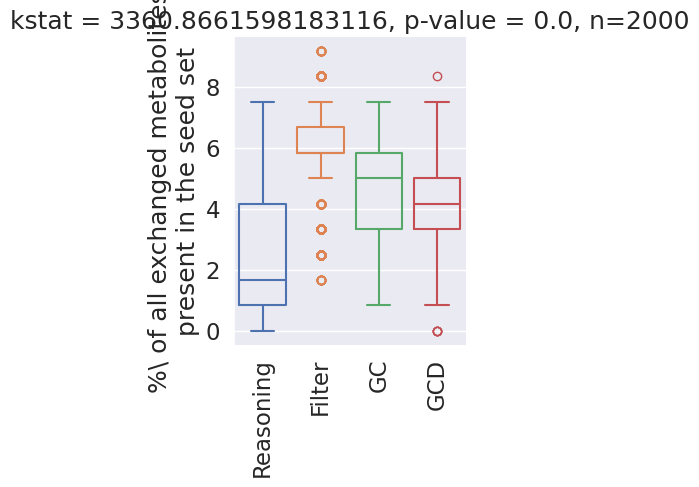

In [79]:
plot_compare_multi(scope_reasoning, scope_fil, scope_gc, scope_gcd,  'percentage_similar_exchange_into_seeds',  
                   y_label="%\ of all exchanged metabolites\npresent in the seed set")

Reasoning:  1.6251689189189187 	 Filter:  1.8078265765765764 	 GC:  1.6422297297297295 	 GCD:  1.7537725225225227


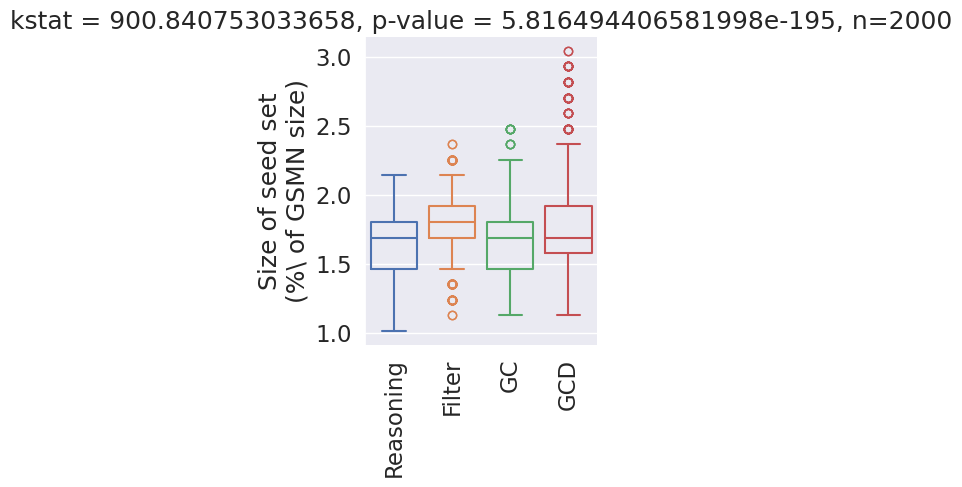

In [80]:
plot_compare_multi(reasoning_size, filter_size, gc_size, gcd_size , 'percent',
             y_label="Size of seed set\n(%\ of GSMN size)")

Reasoning:  73.57714932126697 	 Filter:  73.302092760181 	 GC:  73.06515837104071 	 GCD:  73.37556561085972


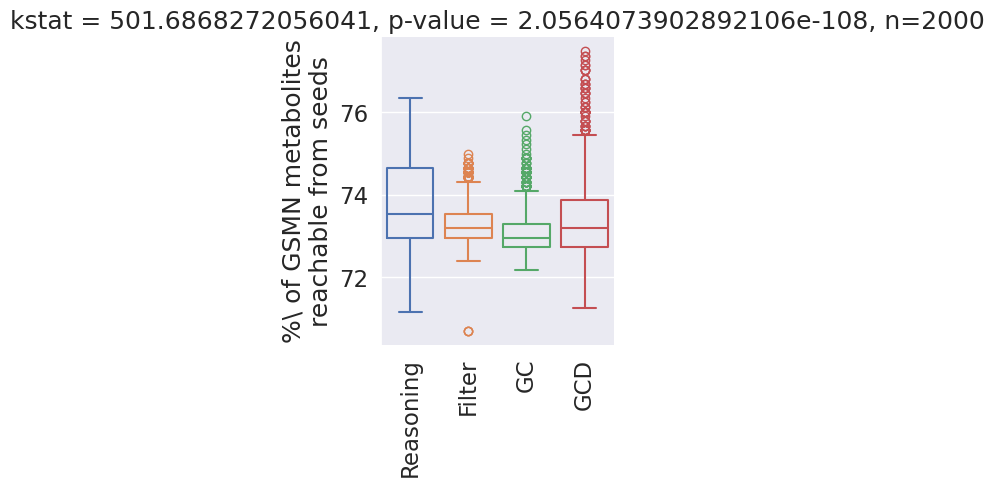

In [38]:
plot_compare_multi(scope_reasoning, scope_fil, scope_gc, scope_gcd,  'percentage_similar',  
                   y_label="%\ of GSMN metabolites\nreachable from seeds")

## Metabolite occurences in solutions

exchange:  50 / total:  188


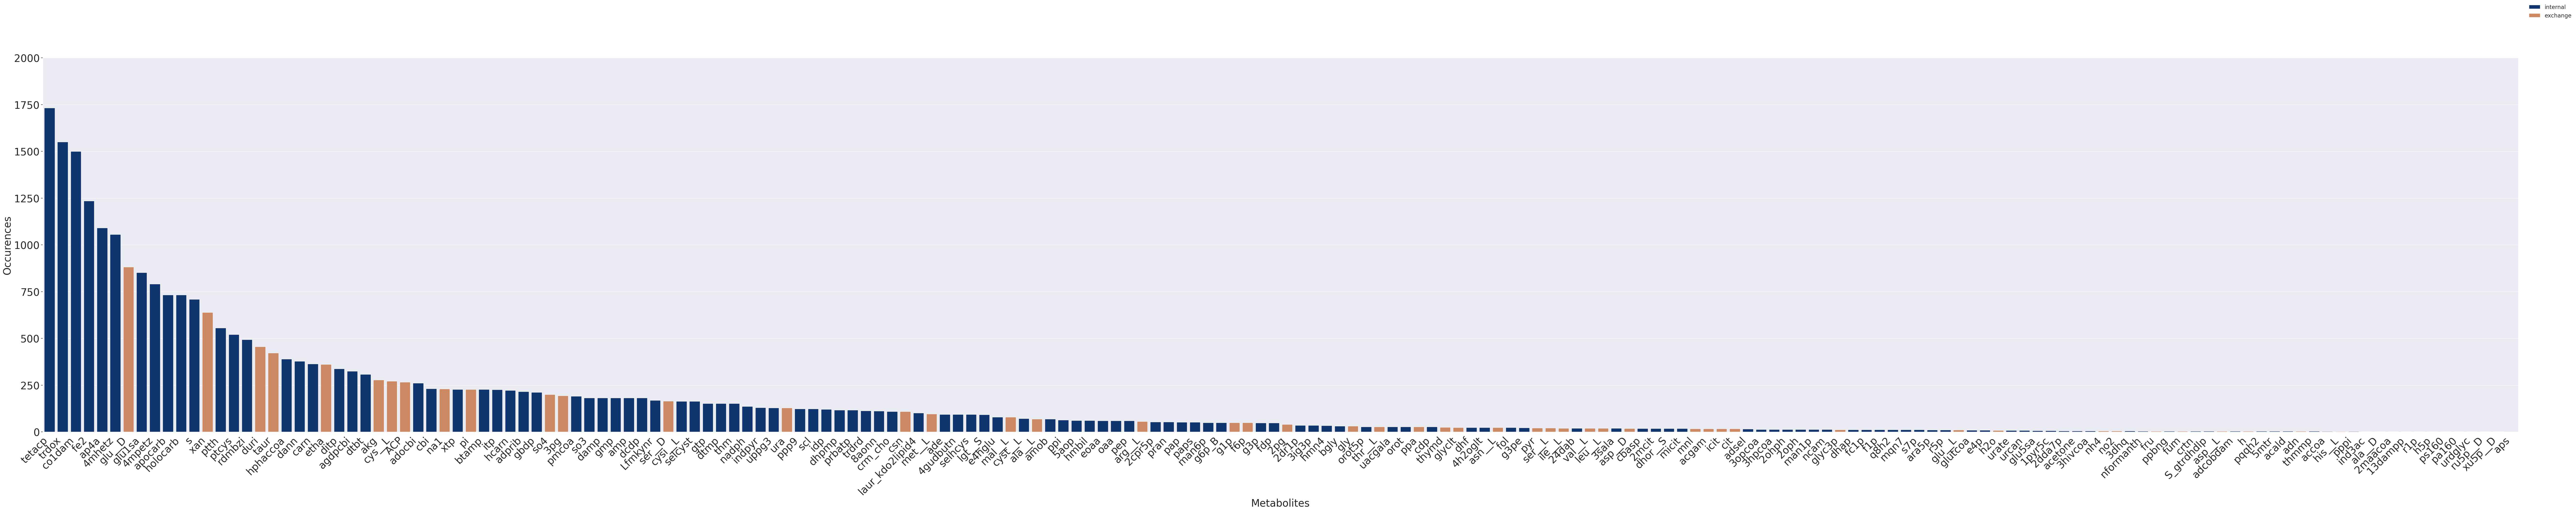

In [57]:
plot_metabolites(metabolites,"reasoning")

exchange:  36 / total:  111


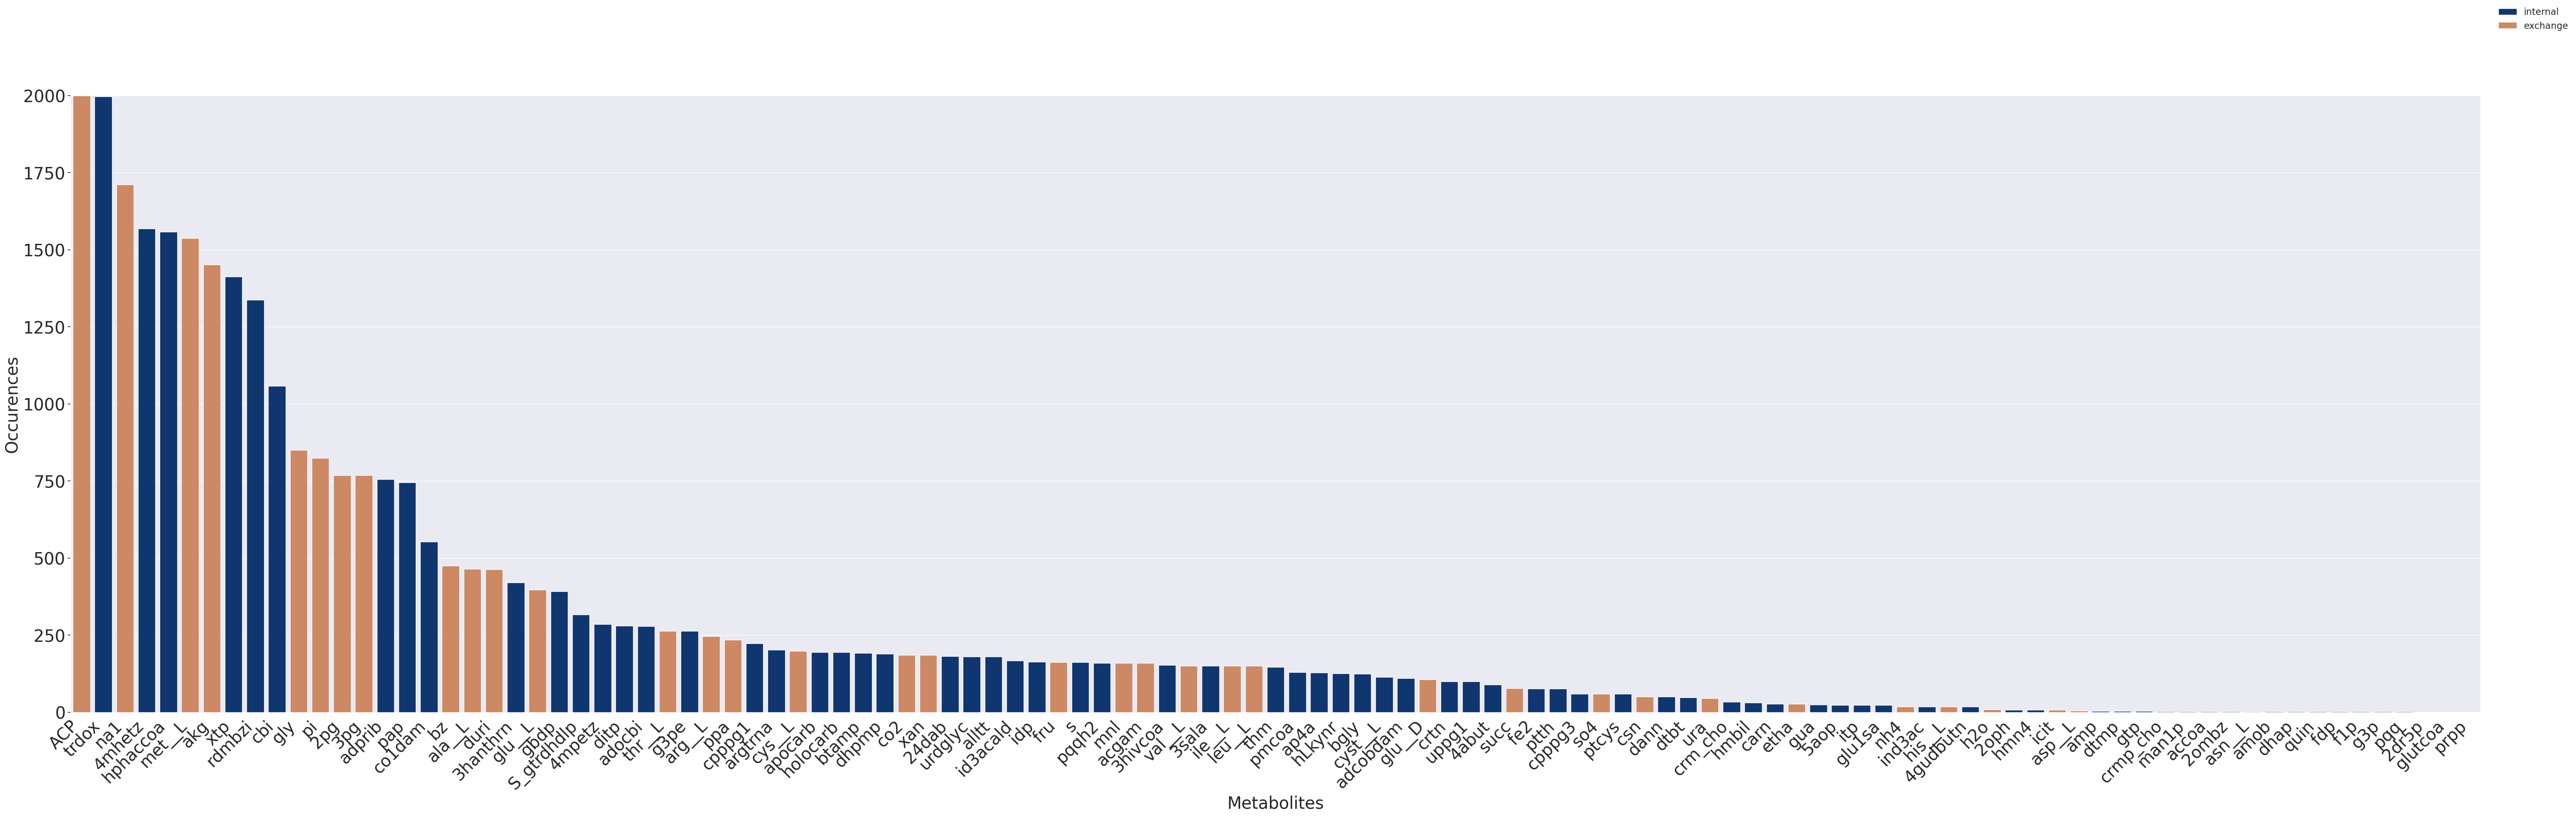

In [58]:
plot_metabolites(metabolites,"filter")

exchange:  49 / total:  130


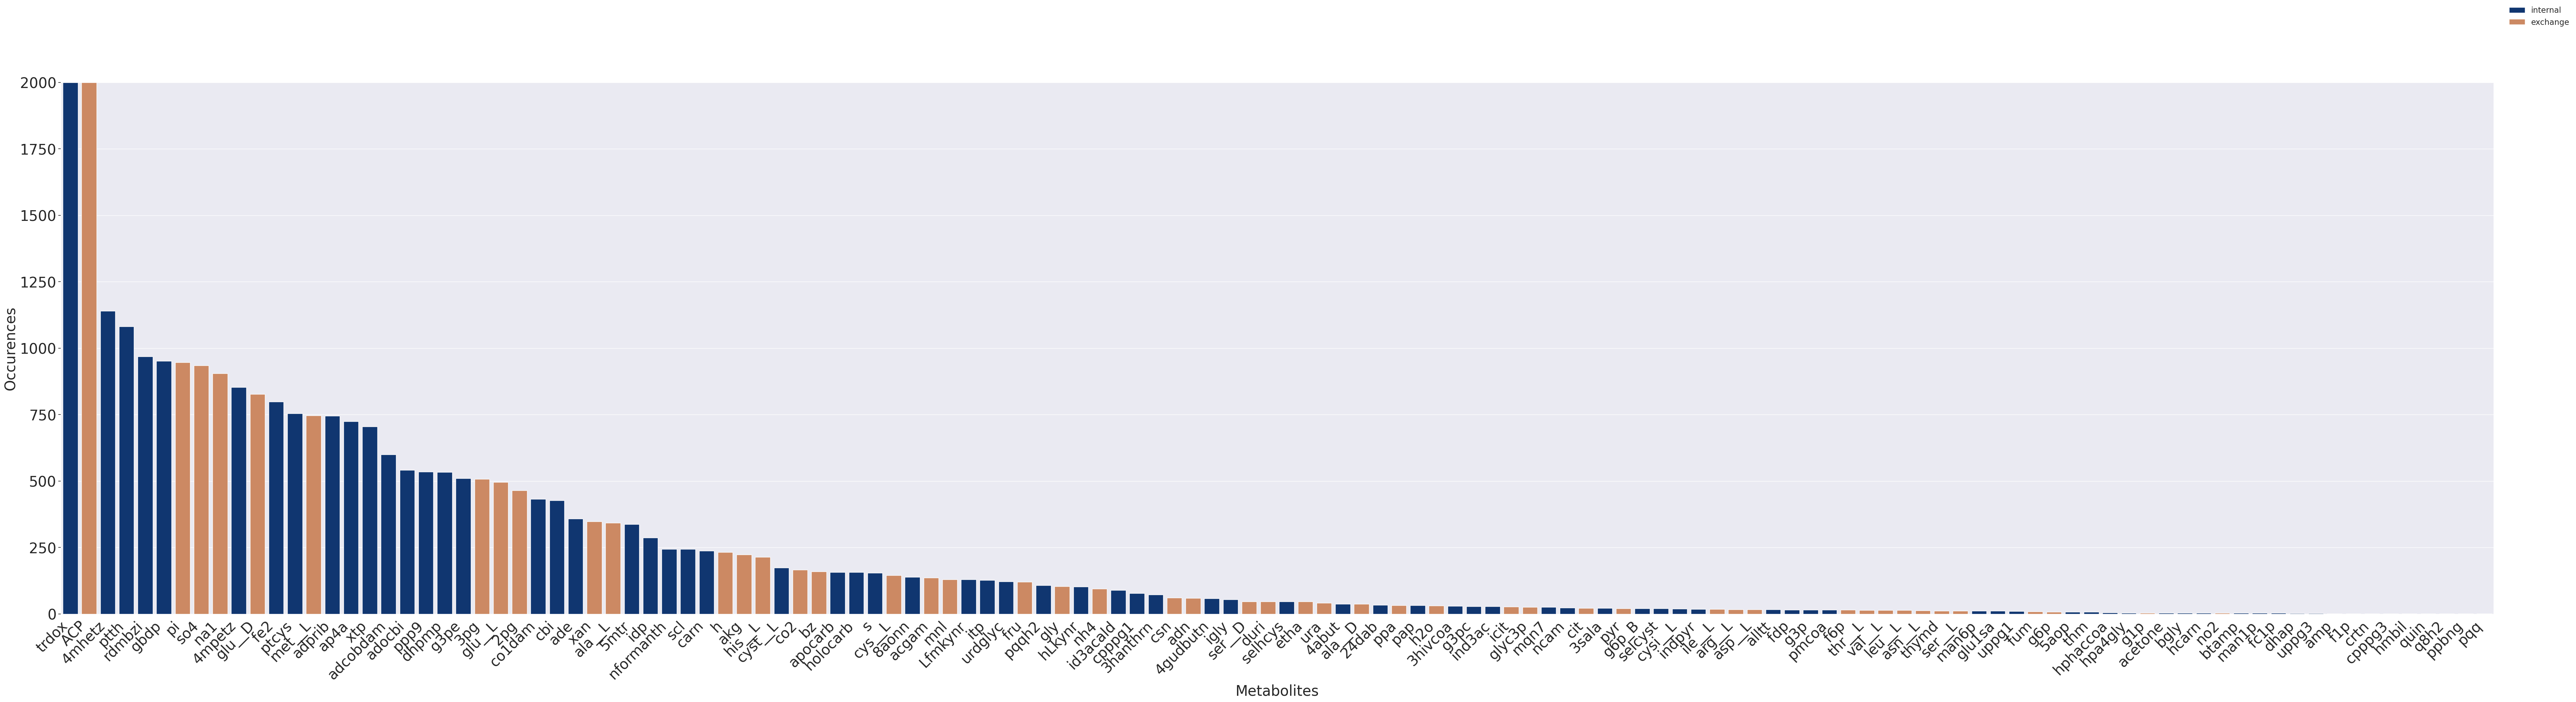

In [59]:
plot_metabolites(metabolites,"gc")

exchange:  38 / total:  141


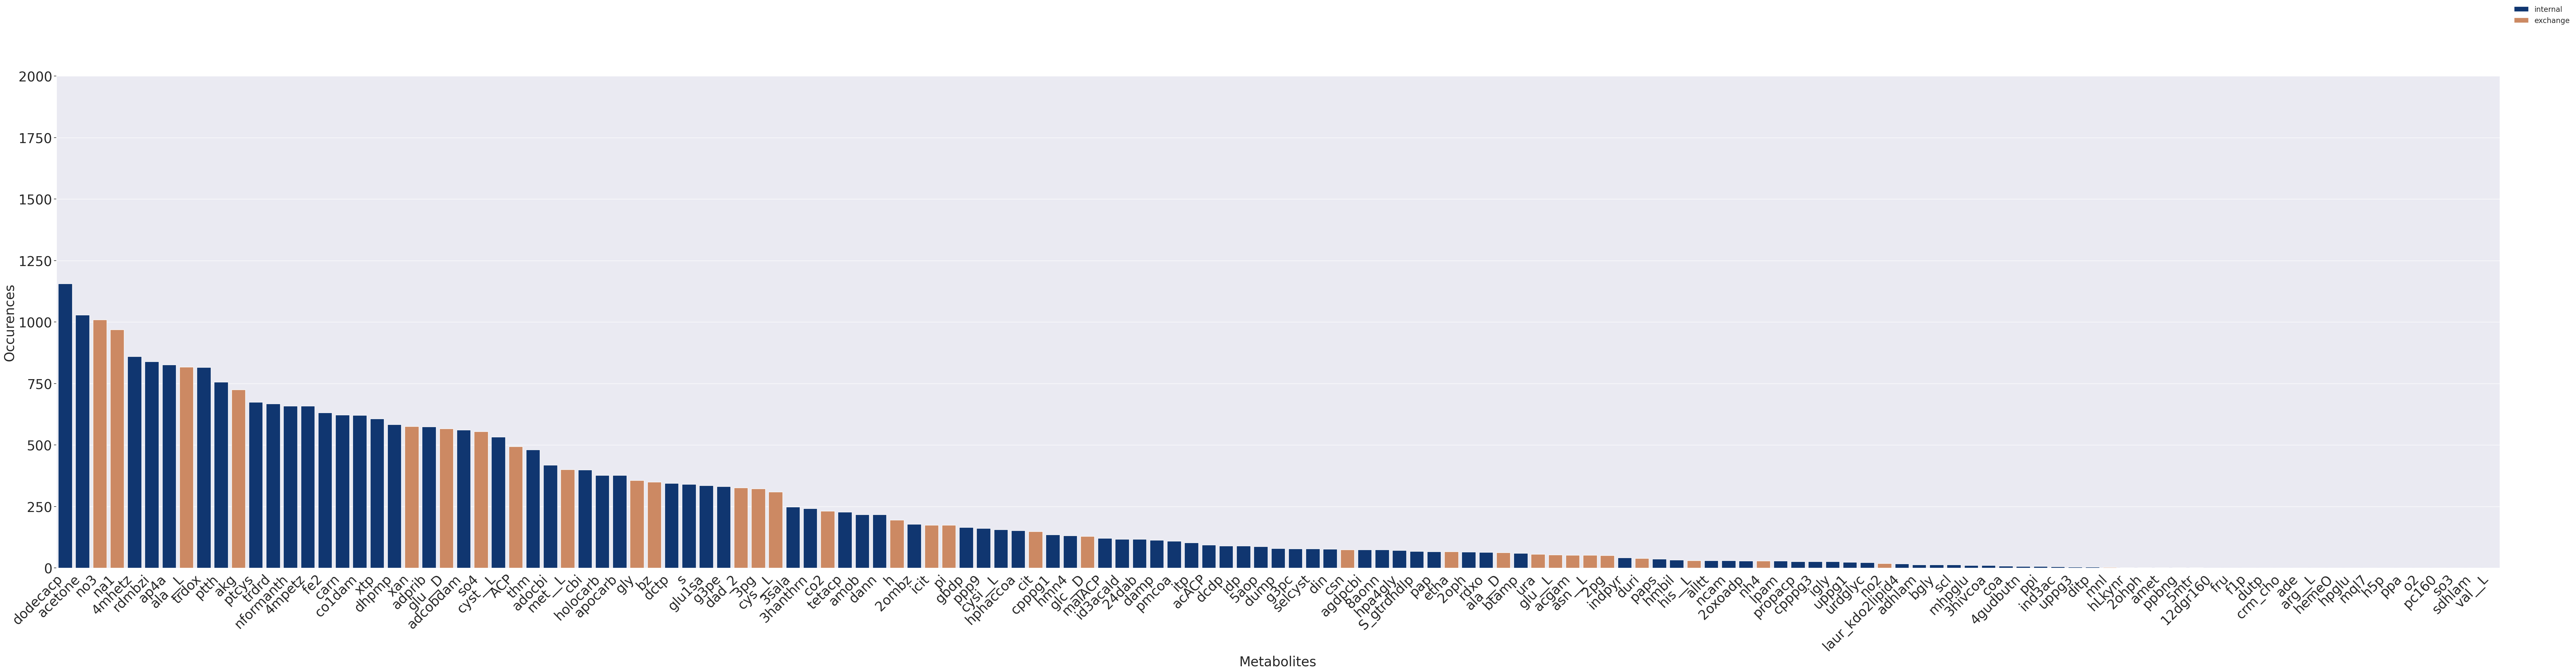

In [60]:
plot_metabolites(metabolites,"gcd")